# Import Libraries

In [1]:
import os
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras

# Preprocessing data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model
from tensorflow.keras.models import Sequential # model
from tensorflow.keras.layers import LSTM, Dense, Embedding # Layers
from tensorflow.keras.utils import to_categorical

2023-12-03 18:58:07.733638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load corpus

### Load Positives

In [2]:
train_tweets, train_labels = [], []

pos = os.getcwd() + '/corpus/arabic_tweets/pos/'  # Replace with the actual directory path

# Iterate over each file in the directory
for filename in os.listdir(pos):
    if filename.endswith('.txt'):  # Select only text files
        file_path = os.path.join(pos, filename)
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            file_content = file.read()
            train_tweets.append(file_content)
            train_labels.append("positive")

### Load Negatives

In [3]:
# Get the txt file negative tweet
pos = os.getcwd() + '/corpus/arabic_tweets/neg/'  # Replace with the actual directory path

# Iterate over each file in the directory
for filename in os.listdir(pos):
    if filename.endswith('.txt'):  # Select only text files
        file_path = os.path.join(pos, filename)
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            file_content = file.read()
            train_tweets.append(file_content)
            train_labels.append("negative")

### Build a dataframe

In [4]:
train_dic = {
    'Tweets' : train_tweets,
    'Labels' : train_labels
}

train_corpus = pd.DataFrame(train_dic)
train_corpus.head(30)

,Tweets,Labels
0,دامك مع #غناتي ، فالك طيب 👍\n,positive
1,على الفطرة السليمه.. الله يعطيه الصحة والعافية...,positive
2,📷 مشجع هلالي ينبذ العنصرية ب لافته أعدها.\n,positive
3,سبحان الله🌸 الحمدلله 💮 لا اله الا الله 🌿 الله ...,positive
4,مشاركتي في مبادراتكم الجميلة فوز وسعادة 💞\n,positive
5,أراك طفلي عند الحب ، وأبي عند ضعفي ، وأخي عند ...,positive
6,"""وسيق الذين اتقوا ربهم إلى الجنة زمرا"" يأبى ال...",positive
7,ربي اغفر لي و لوالدي و لأحبتي و للمؤمنين و الم...,positive
8,يالله يارب على الجمال 💛\n,positive
9,قوافل الا قريش 😂\n,positive


# EDA

##### Explore your dataset

In [5]:
train_corpus.info

<bound method DataFrame.info of                                                   Tweets    Labels
0                          دامك مع #غناتي ، فالك طيب 👍\n  positive
1      على الفطرة السليمه.. الله يعطيه الصحة والعافية...  positive
2            📷 مشجع هلالي ينبذ العنصرية ب لافته أعدها.\n  positive
3      سبحان الله🌸 الحمدلله 💮 لا اله الا الله 🌿 الله ...  positive
4            مشاركتي في مبادراتكم الجميلة فوز وسعادة 💞\n  positive
...                                                  ...       ...
58746  تو اتابع الملخص اياكس شيء عظيم يخوان والله افت...  negative
58747                      يوم كامل وفقط أضفت فقرتين 😑\n  negative
58748  ما رح اتخلى عنك ❤ حتى لو بدي ازعل واتوجع منك 💔...  negative
58749  والله عيب .. البعض يحتاج سنوات ضوئية .. حتى يت...  negative
58750                                عذر اقبح من ذنب 🤔\n  negative

[58751 rows x 2 columns]>

In [6]:
train_corpus.describe()

,Tweets,Labels
count,58751,58751
unique,36723,2
top,بمناسبة فوز الهلال .. 💙 سحب على آيفون XR📱 رتوي...,positive
freq,479,29849


In [7]:
train_corpus.shape

(58751, 2)

In [8]:
train_corpus.columns

Index(['Tweets', 'Labels'], dtype='object')

In [9]:
train_corpus.isnull().sum()

Tweets    0
Labels    0
dtype: int64

In [10]:
len(train_corpus)

58751

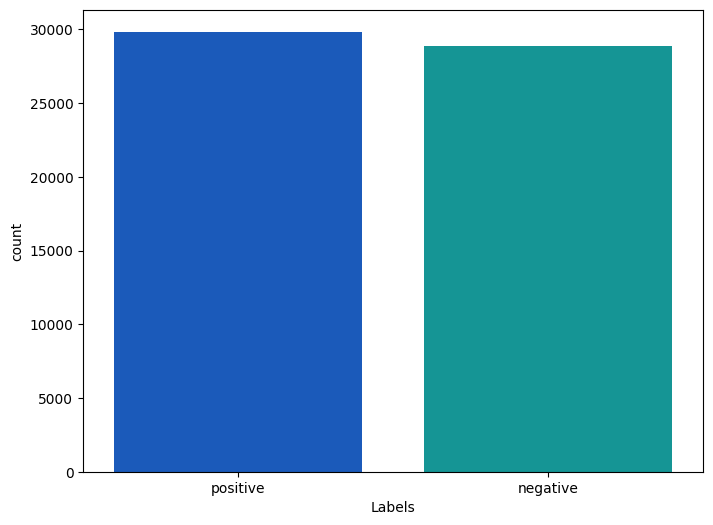

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Labels', data=train_corpus , palette='winter')
plt.show()

### Shuffle all rows

In [12]:
#train_corpus = shuffle(train_corpus)

train_corpus = train_corpus.sample(frac=1, random_state=42)
train_corpus.head()

,Tweets,Labels
32057,سيلينا و بلاك بينك واو\n,negative
44071,👐 يارب ياكريم انصر نصرنا اليوم وكل يوم واكفيه ...,negative
41778,🔸🔸 🖼🖼 🔸🔸 📌 #لوحتي 🔹 #فوائد - #معلومات - #معلوم...,negative
44119,متذكرين لما بتنتظروا بيان التجمع و جدول الاسبو...,negative
7650,هه وش بك زعلتي (المقصد وش هالعادة الي تخليكم ت...,positive


### Data cleaning

**Hint: remove URLs, Hashtags, alphanumeric characters, punctuation marks, stop words, extra spaces**

In [13]:
URL_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
hashtag_pattern = r"#\w+"
mention_pattern = r"@\w+"
alphanumeric_pattern = r"\w*\d\w*"
punctuation_pattern = r"[^\w\s]"
retweet_pattern = r"^RT[\s]+"

In [14]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
    return frozenset(stop_set)

def process_text(text, stop_words):
    # Remove URLs
    text = re.sub(URL_pattern, '', text)
    
    # Remove hashtags
    text = re.sub(hashtag_pattern, '', text)
    
    # Remove mention
    text = re.sub(mention_pattern, '', text)

    # Remove alphanumeric characters
    text = re.sub(alphanumeric_pattern, '', text)

    # Remove punctuation marks
    text = re.sub(punctuation_pattern, '', text)
    
    # Remove Retweet marks
    text = re.sub(retweet_pattern, '', text)

    # Remove stop words using the provided set
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = ' '.join(text.split())
    return text

#### Now Clean your text using above function or implement it from scrach

In [15]:
stop_words = load_stopwords('/Users/nadam/Desktop/RNN_Lab1/corpus/Stop_Words.txt')

df=pd.Series(train_corpus['Tweets'])

def clean_text(text):
    return process_text(text, stop_words)

cleaned_tweets= df.apply(clean_text)
cleaned_tweets.head(20)

32057                                 سيلينا بلاك بينك واو
44071    يارب ياكريم انصر نصرنا وكل واكفيه شر الظلم وال...
41778                                                    م
44119    متذكرين لما بتنتظروا بيان التجمع جدول الاسبوع ...
7650     هه وش بك زعلتي المقصد وش هالعادة الي تخليكم تج...
44899    لماذا تفعل شيئا يجعلني أشعر بأنك تستحق أعنيه أجلك
30597                                            يسمى عزلة
17856    يخلق الله شيئا أقوى الدعاء جعله أقوى أقداره أق...
16051                   ياصباح الحب ومساء الحب لحبيبة قلبي
53940    انتي اكتر يا فطوم والله شهر صعب ربنا يعديه علي...
43033                                            مسكين انا
19545                  نخلة الجنة سبحان الله العظيم وبحمده
28346    هالصيف شاء الله بورتلاند فالطبيعة تعجبك ومره ح...
45307    الاقي نفس وين الاقي نفسي الفضاء النجوم وبجانب ...
9024     انجاز بستحق انو نفرح بيهو لكننا انتظار الفرح ا...
21190    هما بيرقصو اغنيه وادى رقصه الكرانبه يا أبا يا ...
1227              جميل ترا جميل يرتويت لك بحد ذاته شي جم

#### Extra: you could do stemming or lemmatization before training

In [16]:

import spacy
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


In [17]:
'''
def apply_stemming(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def apply_lemmatization(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)
'''

"\ndef apply_stemming(text):\n    tokens = text.split()\n    stemmed_tokens = [stemmer.stem(token) for token in tokens]\n    return ' '.join(stemmed_tokens)\n\ndef apply_lemmatization(text):\n    doc = nlp(text)\n    lemmatized_tokens = [token.lemma_ for token in doc]\n    return ' '.join(lemmatized_tokens)\n"

In [18]:
'''
for i in range(train_corpus.shape[0]):
    processed_text = process_text(train_corpus.iloc[i, train_corpus.columns.get_loc('Tweets')], stop_words)
    stemmed_text = apply_stemming(processed_text)  
    train_corpus.iloc[i, train_corpus.columns.get_loc('Tweets')] = stemmed_text
'''

"\nfor i in range(train_corpus.shape[0]):\n    processed_text = process_text(train_corpus.iloc[i, train_corpus.columns.get_loc('Tweets')], stop_words)\n    stemmed_text = apply_stemming(processed_text)  \n    train_corpus.iloc[i, train_corpus.columns.get_loc('Tweets')] = stemmed_text\n"

In [19]:
cleaned_tweets.tail()

54343    اللهم ارحم موتانا اغسل قبورهم غسلت الارض بالمط...
38158    أجمل الأماكن مررت أثناء احدى زياراتي للعاصمة ا...
860      الهلال ينتصر لكنه بعيد جدا مستواه إهدار غريب ل...
15795                                  هه توسع راسه المربع
56422                                              لك وحشه
Name: Tweets, dtype: object

In [20]:
len(train_corpus)

58751

## Tokenizer

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token='<oov>') 
tokenizer.fit_on_texts(cleaned_tweets) 
sequences = tokenizer.texts_to_sequences(cleaned_tweets)
num_words = len(tokenizer.word_index) + 1

print("Total number of words: ", num_words)

Total number of words:  77383


# Split data to train and test

In [22]:
input_sequences = []
labels = []
for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence[:-1])
        labels.append(n_gram_sequence[-1])


split_ratio = 0.8 # 80% for the train
split_index = int(split_ratio * len(input_sequences))
x_train, y_train = input_sequences[:split_index], labels[:split_index]
x_test, y_test = input_sequences[split_index:], labels[split_index:] # 20 for the test

In [25]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, tokenizer, sequences, labels, batch_size, max_sequence_length, num_classes):
        self.tokenizer = tokenizer
        self.sequences = sequences
        self.labels = labels
        self.batch_size = batch_size
        self.max_sequence_length = max_sequence_length
        self.num_classes = num_classes

    def __len__(self):
        return len(self.sequences) // self.batch_size

    def __getitem__(self, index):
        batch_indices = np.random.choice(len(self.sequences), size=self.batch_size, replace=False)
        batch_sequences = [self.sequences[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        x = pad_sequences(batch_sequences, maxlen=self.max_sequence_length)
        y = self.one_hot_encode(batch_labels)

        return x, y

    def one_hot_encode(self, labels):
        encoded_labels = np.zeros((len(labels), self.num_classes), dtype=np.float32)
        for i, label in enumerate(labels):
            encoded_labels[i, label] = 1.0
        return encoded_labels

# Text to sequence

In [26]:
tokenizer.fit_on_texts(cleaned_tweets)
#sequences = tokenizer.texts_to_sequences(cleaned_tweets)


# Pad sequence

In [27]:
max_sequence_length = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length)

In [28]:
epoch = 20 # 
batch_size = 64 


train_data_generator = DataGenerator(tokenizer, x_train, y_train, batch_size, max_sequence_length, num_words)
test_data_generator = DataGenerator(tokenizer, x_test, y_test, batch_size, max_sequence_length, num_words)

# RNN Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=max_sequence_length))
model.add(SimpleRNN(100, return_sequences=True))
model.add(SimpleRNN(100))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_data_generator, epochs=10, batch_size=512)

Epoch 1/10
5932/5975 [============================>.] - ETA: 15s - loss: 3.5405e-04 - accuracy: 1.0000

In [ ]:
model.summary()

# LSTM Model

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim= num_words, output_dim=100, input_length=max_sequence_length))
model_LSTM.add(LSTM(units=128))
model_LSTM.add(Dense(units=1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.fit(train_data_generator, epochs=3, batch_size=256)

# Evaulation and Comparsion

In [ ]:
loss, accuracy = model.evaluate(test_data_generator)
print("Loss:", loss)
print("Accuracy:", accuracy)

In [ ]:
model = tf.keras.models.load_model('model.h5')

In [ ]:
pd.DataFrame(samples.items(), columns=["start", "predicted"])